# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Karim ROCHD
* Petko PETKOV
* Melissa HAFIS

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [2]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.5.2
nltk's version: 3.9.1
pandas's version: 2.2.3


[nltk_data] Downloading package punkt to /home/karim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [5]:
# DATA = Path("../data")
DATA = Path("")
TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [6]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [7]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000003445,Q:\n\nWhat does this pendant/symbol mean?\n\nT...,mythology,0
mythology.stackexchange_0000002113,Q:\n\nDid Loki give birth to a monster?\n\nLok...,mythology,0
mythology.stackexchange_0000005995,Q:\n\nIs there a referenced kill-count for Hec...,mythology,0
mythology.stackexchange_0000002595,Q:\n\nRune Identification needed for tattoo\n\...,mythology,0
mythology.stackexchange_0000001077,Q:\n\nDid Hercules complete his labors as desc...,mythology,0
...,...,...,...
portuguese.stackexchange_0000005420,"Q:\n\nComo Traduzir ""Pastoral"" para o Inglês\n...",portuguese,5
portuguese.stackexchange_0000003292,Q:\n\nTranslation for “working-class area”?\n\...,portuguese,5
portuguese.stackexchange_0000008291,"Q:\n\nQuando foi que a palavra ""transar"" passo...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

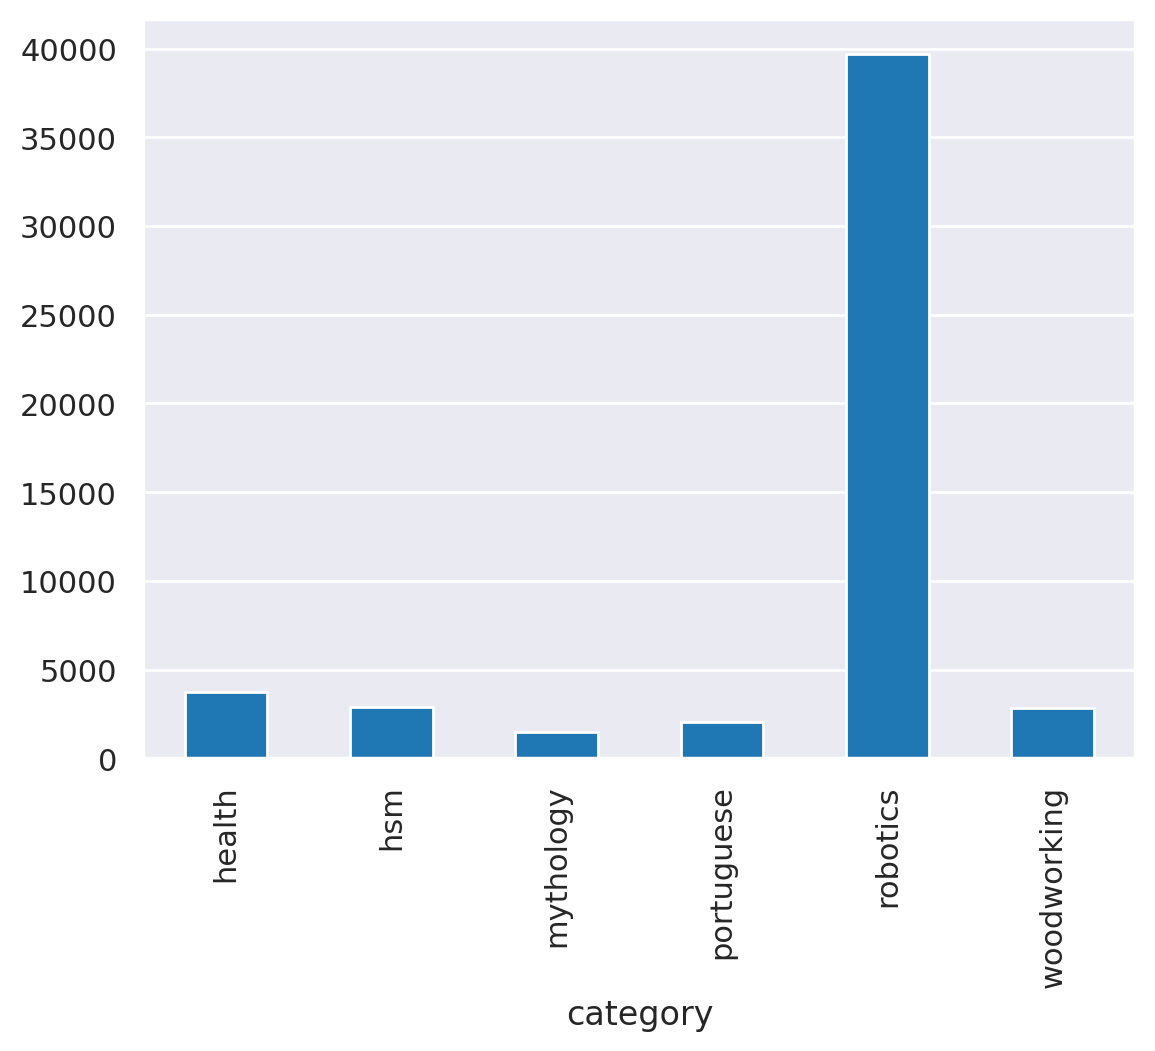

In [8]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [9]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} =
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [10]:
# tf_idf = ...
tf_idf = TfidfVectorizer()
tf_idf_xs = tf_idf.fit_transform(corpus).toarray()

tf_idf_df = pd.DataFrame(tf_idf_xs, index=corpus, columns=tf_idf.get_feature_names_out())
tf_idf_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [11]:
ys = all_df.cat_id.values

In [12]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

In [13]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (52682, 5000)
ys.shape = (52682,)


In [14]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

In [15]:
from sklearn.naive_bayes import MultinomialNB

# CountVectorizer with MultinomialNB
count_vec = CountVectorizer(max_features=5000)
count_xs = count_vec.fit_transform(all_df.text)

X_train_count, X_test_count, y_train, y_test = train_test_split(
    count_xs, ys, test_size=0.3, random_state=42
)

mnb_count = MultinomialNB()
mnb_count.fit(X_train_count, y_train)
y_pred_count = mnb_count.predict(X_test_count)

print("CountVectorizer Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_count):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count))

# TfidfVectorizer with MultinomialNB
tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf_xs = tfidf_vec.fit_transform(all_df.text)

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    tfidf_xs, ys, test_size=0.3, random_state=42
)

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = mnb_tfidf.predict(X_test_tfidf)

print("\nTfidfVectorizer Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

CountVectorizer Results:
Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       483
           1       0.82      1.00      0.90       876
           2       1.00      0.97      0.98     11835
           3       0.82      0.96      0.88       865
           4       0.94      0.97      0.95      1158
           5       1.00      0.88      0.94       588

    accuracy                           0.97     15805
   macro avg       0.91      0.96      0.93     15805
weighted avg       0.97      0.97      0.97     15805



KeyboardInterrupt: 

TF-IDF performed better with 98.4% accuracy compared to Count Vectorizer's 96.7%. The biggest improvement was in minority categories, where TF-IDF's weighting of important words helped distinguish between similar documents more effectively. For example, precision in category 1 improved from 82% to 92%.

#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count Vectorizer
count_vec = CountVectorizer(max_features=5000)
count_xs = count_vec.fit_transform(all_df.text)
X_train_count, X_test_count, y_train, y_test = train_test_split(count_xs, ys, test_size=0.3, random_state=42)

# TF-IDF
tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf_xs = tfidf_vec.fit_transform(all_df.text)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_xs, ys, test_size=0.3, random_state=42)

# MultinomialNB with CountVectorizer
mnb_count = MultinomialNB()
mnb_count.fit(X_train_count, y_train)
mnb_count_pred = mnb_count.predict(X_test_count)

print("MultinomialNB + CountVectorizer:")
print(f"Accuracy: {accuracy_score(y_test, mnb_count_pred):.3f}")
print(classification_report(y_test, mnb_count_pred))

# MultinomialNB with TF-IDF
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)
mnb_tfidf_pred = mnb_tfidf.predict(X_test_tfidf)

print("\nMultinomialNB + TF-IDF:")
print(f"Accuracy: {accuracy_score(y_test, mnb_tfidf_pred):.3f}")
print(classification_report(y_test, mnb_tfidf_pred))

# GaussianNB with CountVectorizer
gnb_count = GaussianNB()
gnb_count.fit(X_train_count.toarray(), y_train)
gnb_count_pred = gnb_count.predict(X_test_count.toarray())

print("\nGaussianNB + CountVectorizer:")
print(f"Accuracy: {accuracy_score(y_test, gnb_count_pred):.3f}")
print(classification_report(y_test, gnb_count_pred))

# GaussianNB with TF-IDF
gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_train_tfidf.toarray(), y_train)
gnb_tfidf_pred = gnb_tfidf.predict(X_test_tfidf.toarray())

print("\nGaussianNB + TF-IDF:")
print(f"Accuracy: {accuracy_score(y_test, gnb_tfidf_pred):.3f}")
print(classification_report(y_test, gnb_tfidf_pred))


MultinomialNB + CountVectorizer:
Accuracy: 0.967
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       483
           1       0.82      1.00      0.90       876
           2       1.00      0.97      0.98     11835
           3       0.82      0.96      0.88       865
           4       0.94      0.97      0.95      1158
           5       1.00      0.88      0.94       588

    accuracy                           0.97     15805
   macro avg       0.91      0.96      0.93     15805
weighted avg       0.97      0.97      0.97     15805


MultinomialNB + TF-IDF:
Accuracy: 0.984
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       483
           1       0.92      1.00      0.96       876
           2       1.00      0.99      0.99     11835
           3       0.89      0.97      0.93       865
           4       0.96      0.98      0.97      1158
           5       1.00      0.91      0.9

MultinomialNB with TF-IDF was the clear winner with 98.4% accuracy, outperforming both GaussianNB variations. While GaussianNB did decently with both vectorizers (97.2% with TF-IDF), it struggled more with minority classes, particularly category 0 and 3. Interestingly, both classifiers performed better with TF-IDF than with CountVectorizer, suggesting that term weighting really helps in distinguishing between document categories.

#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Translate this result into a sentence

<Figure size 1000x800 with 0 Axes>

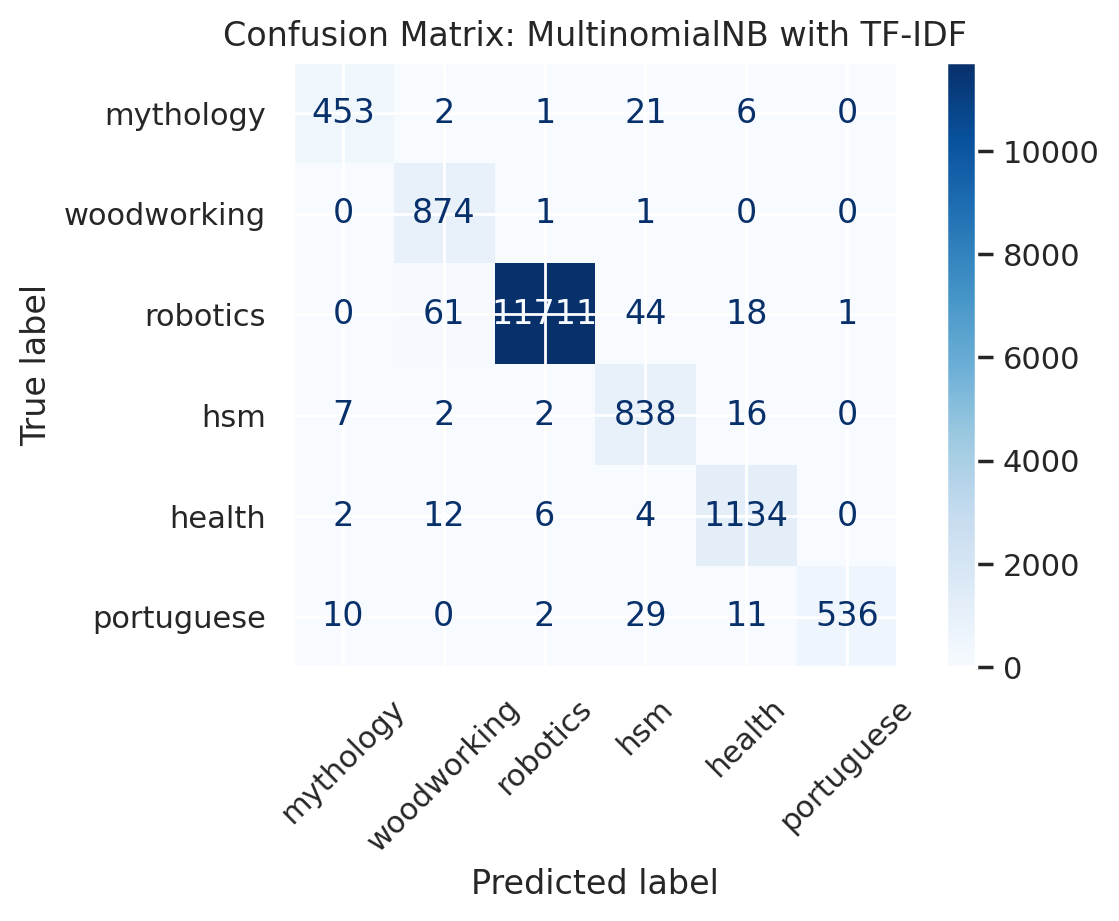

In [ ]:
# Get predictions from our best model (MultinomialNB with TF-IDF)
cm = confusion_matrix(y_test, mnb_tfidf_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CORPORA)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: MultinomialNB with TF-IDF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The confusion matrix shows strong classification performance across all categories, with robotics having the highest number of correct predictions (11,711). The main areas of confusion are between robotics and woodworking (61 misclassifications). Overall, the diagonal dominance indicates excellent classifier performance.

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [ ]:
# Original TF-IDF (with stop words)
tfidf_original = TfidfVectorizer(max_features=5000)
xs_original = tfidf_original.fit_transform(all_df.text)

# TF-IDF without stop words
tfidf_no_stop = TfidfVectorizer(max_features=5000, stop_words='english')
xs_no_stop = tfidf_no_stop.fit_transform(all_df.text)

print(f"Matrix size with stop words: {xs_original.shape}")
print(f"Matrix size without stop words: {xs_no_stop.shape}")

# Train and test
X_train_no_stop, X_test_no_stop, y_train, y_test = train_test_split(xs_no_stop, ys, test_size=0.3, random_state=42)

mnb_no_stop = MultinomialNB()
mnb_no_stop.fit(X_train_no_stop, y_train)
y_pred_no_stop = mnb_no_stop.predict(X_test_no_stop)

print("\nAccuracy without stop words:", accuracy_score(y_test, y_pred_no_stop))
print("\nClassification Report without stop words:")
print(classification_report(y_test, y_pred_no_stop))

Matrix size with stop words: (52682, 5000)
Matrix size without stop words: (52682, 5000)

Accuracy without stop words: 0.9846251186333439

Classification Report without stop words:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       483
           1       0.92      1.00      0.96       876
           2       1.00      0.99      0.99     11835
           3       0.90      0.97      0.93       865
           4       0.96      0.98      0.97      1158
           5       1.00      0.94      0.97       588

    accuracy                           0.98     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.98      0.98     15805



The current model shows a very small improvement, with accuracy increasing by 0.001 and minor gains in precision. The differences are likely not statistically significant. # TODO check this later

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

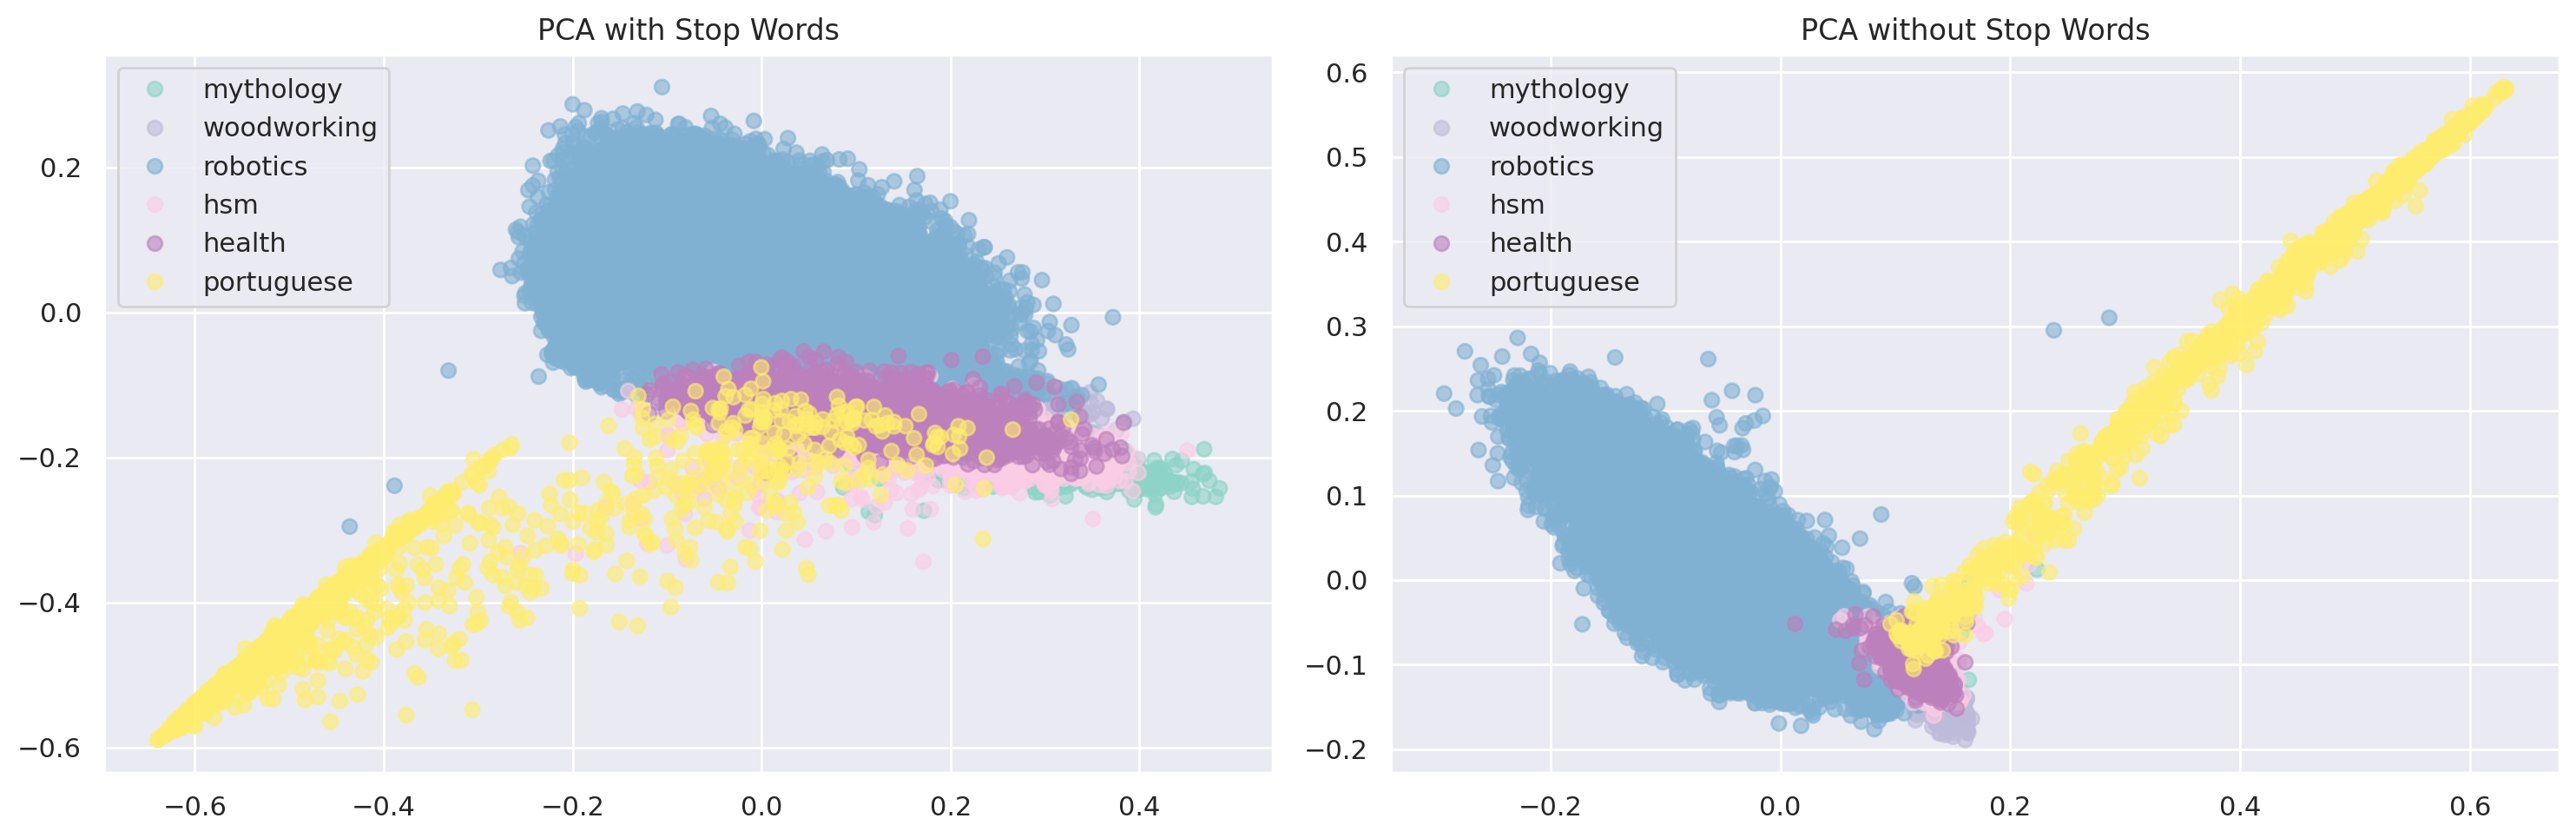

In [ ]:
from sklearn.decomposition import PCA

# Original TF-IDF
tfidf_original = TfidfVectorizer(max_features=5000)
xs_original = tfidf_original.fit_transform(all_df.text).toarray()

# TF-IDF without stop words
tfidf_no_stop = TfidfVectorizer(max_features=5000, stop_words='english')
xs_no_stop = tfidf_no_stop.fit_transform(all_df.text).toarray()

# Apply PCA to both
pca = PCA(n_components=2)
xs_pca_original = pca.fit_transform(xs_original)
xs_pca_no_stop = pca.fit_transform(xs_no_stop)

# Plot both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot with stop words
scatter1 = ax1.scatter(xs_pca_original[:, 0], xs_pca_original[:, 1], c=ys, cmap='Set3', alpha=0.6)
ax1.set_title('PCA with Stop Words')
ax1.legend(handles=scatter1.legend_elements()[0], labels=CORPORA)

# Plot without stop words  
scatter2 = ax2.scatter(xs_pca_no_stop[:, 0], xs_pca_no_stop[:, 1], c=ys, cmap='Set3', alpha=0.6)
ax2.set_title('PCA without Stop Words')
ax2.legend(handles=scatter2.legend_elements()[0], labels=CORPORA)

plt.tight_layout()
plt.show()

Removing stop words really helped separate the categories better. The plot without stop words shows clearer clusters, especially for Portuguese content which forms a distinct diagonal line. The robotics category (blue) also appears more concentrated. In contrast, the plot with stop words shows more overlap between categories, particularly between health, hsm, and mythology. This improved separation makes sense since removing common English words lets the model focus on the unique, topic-specific vocabulary that better distinguishes between categories.

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Original TF-IDF (with stop words)
tfidf_original = TfidfVectorizer(max_features=5000)
X_train_original, X_test_original, y_train, y_test = train_test_split(all_df.text, ys, test_size=0.3, random_state=42)

X_train_tfidf = tfidf_original.fit_transform(X_train_original).toarray()
X_test_tfidf = tfidf_original.transform(X_test_original).toarray()

# PCA and scaling for original
pca = PCA(n_components=2)
scaler = MinMaxScaler()
X_train_pca = pca.fit_transform(X_train_tfidf)
X_test_pca = pca.transform(X_test_tfidf)
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# No stop words
tfidf_no_stop = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf_no_stop = tfidf_no_stop.fit_transform(X_train_original).toarray()
X_test_tfidf_no_stop = tfidf_no_stop.transform(X_test_original).toarray()

# PCA and scaling for no stop words
pca_no_stop = PCA(n_components=2)
scaler_no_stop = MinMaxScaler()
X_train_pca_no_stop = pca_no_stop.fit_transform(X_train_tfidf_no_stop)
X_test_pca_no_stop = pca_no_stop.transform(X_test_tfidf_no_stop)
X_train_pca_no_stop_scaled = scaler_no_stop.fit_transform(X_train_pca_no_stop)
X_test_pca_no_stop_scaled = scaler_no_stop.transform(X_test_pca_no_stop)

# Models evaluation
models = {
   "MultinomialNB with stop words": MultinomialNB(),
   "GaussianNB with stop words": GaussianNB(),
   "MultinomialNB without stop words": MultinomialNB(),
   "GaussianNB without stop words": GaussianNB()
}

results = {}
for name, model in models.items():
   if "with stop words" in name:
       model.fit(X_train_pca_scaled, y_train)
       pred = model.predict(X_test_pca_scaled)
   else:
       model.fit(X_train_pca_no_stop_scaled, y_train)
       pred = model.predict(X_test_pca_no_stop_scaled)
       
   results[name] = {
       "accuracy": accuracy_score(y_test, pred),
       "report": classification_report(y_test, pred)
   }
   print(f"\n{name}:")
   print(f"Accuracy: {results[name]['accuracy']:.3f}")
   print("Classification Report:")
   print(results[name]['report'])


MultinomialNB with stop words:
Accuracy: 0.749
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       483
           1       0.00      0.00      0.00       876
           2       0.75      1.00      0.86     11835
           3       0.00      0.00      0.00       865
           4       0.00      0.00      0.00      1158
           5       0.00      0.00      0.00       588

    accuracy                           0.75     15805
   macro avg       0.12      0.17      0.14     15805
weighted avg       0.56      0.75      0.64     15805


GaussianNB with stop words:
Accuracy: 0.854
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.32      0.39       483
           1       0.47      0.53      0.50       876
           2       0.98      0.96      0.97     11835
           3       0.43      0.45      0.44       865
           4       0.43      0.60      0.50    

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

It does not work with both classifiers because the PCA outputs negative values and MultinomialNB can't take negative values as input, but we can solve that using minmax scaler.

MultinomialNB:
- Identical performance with/without stop words (75% accuracy)
- Poor performance overall - only predicts class 2
- Zero precision/recall for all classes except class 2

GaussianNB:
- Slightly better with stop words (85.4% vs 84.2%)
- With stop words: Better balanced performance across classes
- Without stop words: Fails completely on class 0, very poor on class 3

The minimal impact of stop words removal suggests that either:
1. Stop words aren't significant discriminators for this classification task
2. The dimension reduction to 2 components with PCA loses too much discriminative information

GaussianNB handles the reduced feature space better than MultinomialNB, likely due to its ability to model continuous features effectively.

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

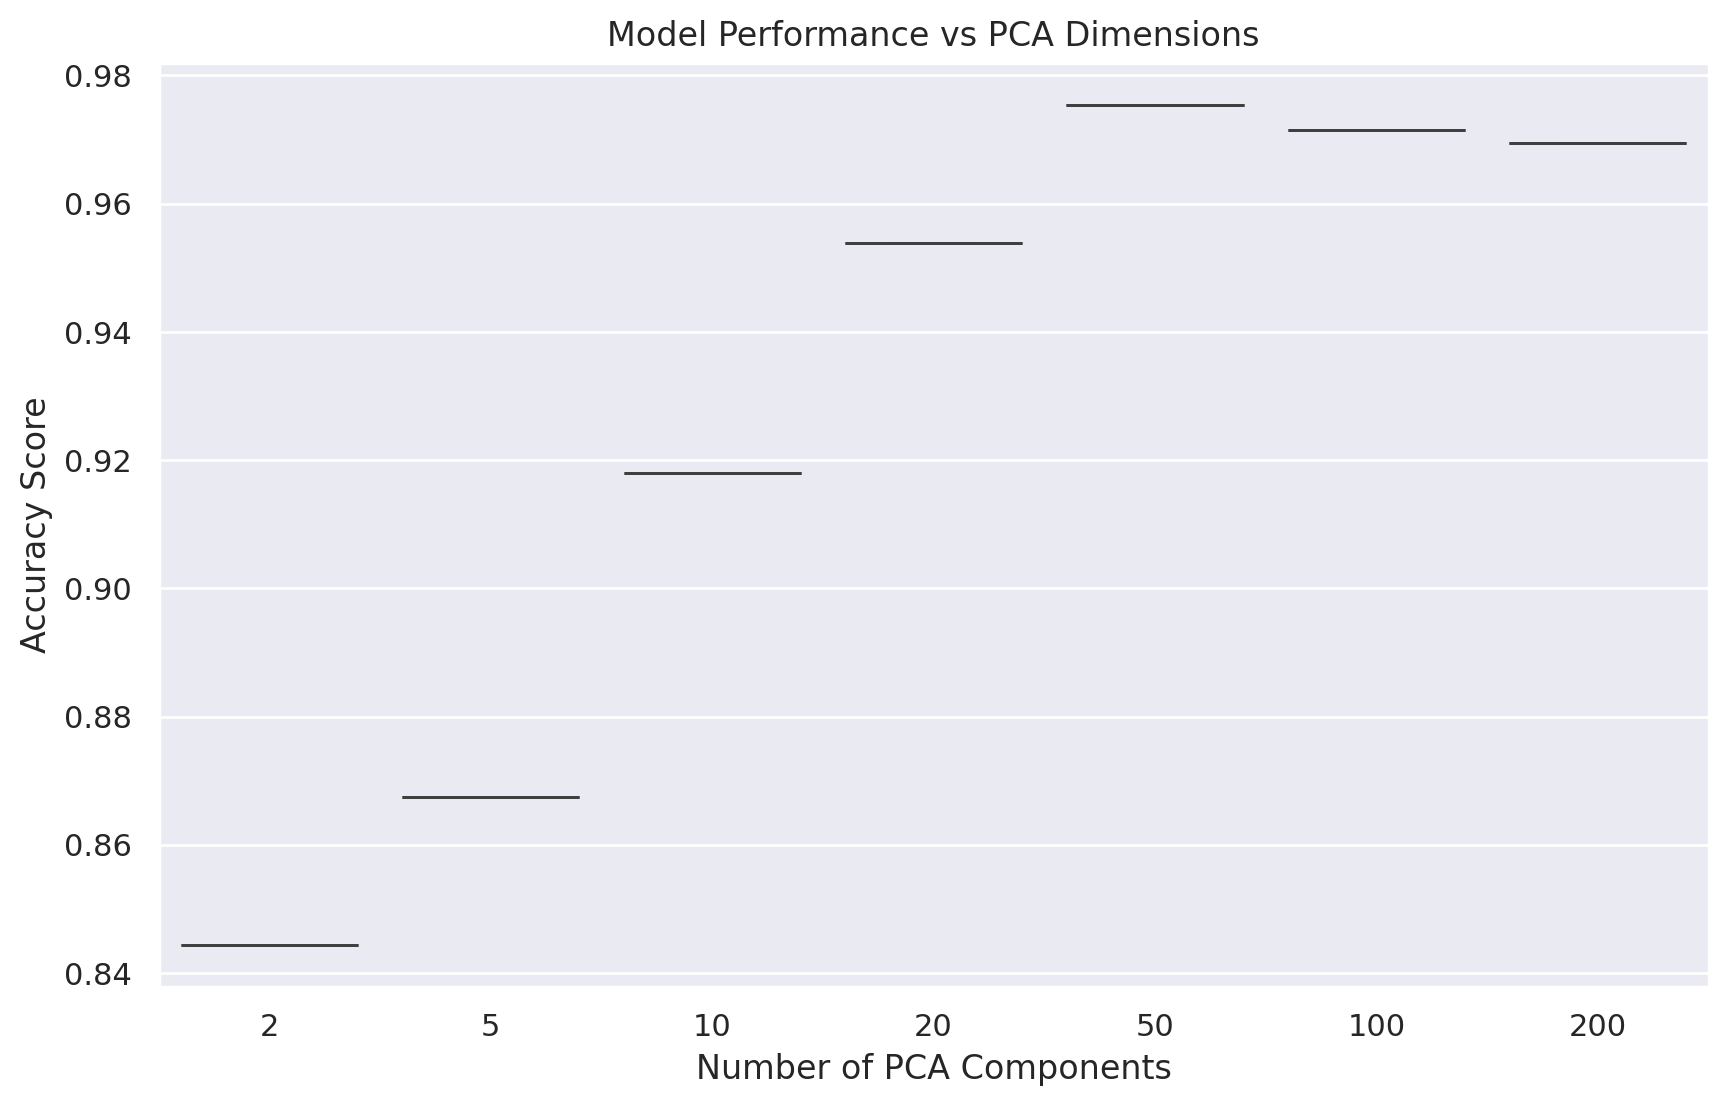

Best number of components: 50
Best score: 0.975


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Create pipeline
pipeline = Pipeline([
    ('pca', PCA()),
    ('scaler', MinMaxScaler()),
    ('classifier', GaussianNB())
])

# Parameter grid
param_grid = {
    'pca__n_components': [2, 5, 10, 20, 50, 100, 200]
}

tfidf_no_stop = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf_no_stop = tfidf_no_stop.fit_transform(all_df.text).toarray()
ys = all_df.cat_id.values
# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_tfidf_no_stop, ys)

# Plot results 
scores = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.boxplot(x='param_pca__n_components', y='mean_test_score', data=scores)
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy Score')
plt.title('Model Performance vs PCA Dimensions')
plt.show()

print(f"Best number of components: {grid_search.best_params_['pca__n_components']}")
print(f"Best score: {grid_search.best_score_:.3f}")

## N-grams features for text classification

*   We will use bigram in this section

In [ ]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [ ]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,00 00
1,000 000
2,000000 000000
3,001 001
4,01 01
...,...
4995,your system
4996,your time
4997,your urdf
4998,your workspace


In [ ]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


In [ ]:
vectorizer_uni = CountVectorizer(
    analyzer="word", max_features=5000,
)
x_uni = vectorizer_uni.fit_transform(all_df.text).toarray()
train_xs_uni, test_xs_uni, train_ys_uni, test_ys_uni = train_test_split(
    x_uni, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs_uni.shape)
print(test_xs_uni.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with bigrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

In [ ]:
# Baseline

model_unigram = MultinomialNB()
model_unigram.fit(train_xs_uni, train_ys_uni)
pred_unigram = model_unigram.predict(test_xs_uni)

# Bigram
model_bigram = MultinomialNB()
model_bigram.fit(train_xs, train_ys)
pred_bigram = model_bigram.predict(test_xs)

# Print results
print("Unigram Results:")
print(f"Accuracy: {accuracy_score(y_test, pred_unigram):.3f}")
print(classification_report(test_ys_uni, pred_unigram))

print("\nBigram Results:")
print(f"Accuracy: {accuracy_score(y_test, pred_bigram):.3f}")
print(classification_report(test_ys, pred_bigram))

Unigram Results:
Accuracy: 0.564
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       433
           1       0.80      1.00      0.89       879
           2       1.00      0.97      0.98     11887
           3       0.85      0.96      0.90       853
           4       0.93      0.98      0.95      1117
           5       1.00      0.90      0.95       636

    accuracy                           0.97     15805
   macro avg       0.91      0.96      0.93     15805
weighted avg       0.97      0.97      0.97     15805


Bigram Results:
Accuracy: 0.548
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       433
           1       0.61      0.96      0.75       879
           2       1.00      0.94      0.96     11887
           3       0.83      0.89      0.86       853
           4       0.77      0.91      0.83      1117
           5       0.98      0.83      0.90       636

    accurac

Bigram results are slightly better than the baseline results

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [ ]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [ ]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [ ]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [ ]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

,freq
is,7
his,4
thi,3
is,3
s i,2
th,1
wh,1


### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [ ]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

,text,category,cat_id
id,,,
woodworking.stackexchange_0000001432,Q:\n\nIs there a reason not to glue a wooden b...,woodworking,1
woodworking.stackexchange_0000002337,Q:\n\nBest knockdown joint for loft bed?\n\nWh...,woodworking,1
woodworking.stackexchange_0000008153,Q:\n\nWhy do we use slats to make outside swin...,woodworking,1
woodworking.stackexchange_0000010780,Q:\n\nImplications of gluing a panel made of h...,woodworking,1
woodworking.stackexchange_0000013108,Q:\n\nCan I use an oversized blade on a radial...,woodworking,1


In [ ]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

Is there a reason not to glue a wooden bolt into its threads?

I am eagerly awaiting the arrival of my new tapping set from Beall and one of the uses I was thinking about was creating a mallet--turn a head and then tap a hole and screw in a wooden handle (I have a couple other similar projects on the docket as well).
Now other 


In [17]:
import nltk
from nltk.tokenize import word_tokenize
import collections
import pandas as pd

def create_ngrams(text, n=2):
    # Tokenize and normalize
    tokens = word_tokenize(text.lower())
    
    # Create n-grams
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i + n])
        ngrams.append(ngram)
    
    return ngrams

# Process all woodworking texts
wood_df = all_df[all_df.category == "woodworking"]
woodworking_texts = wood_df.text.tolist()
all_ngrams = collections.Counter()

# Generate and count n-grams for each text
for text in woodworking_texts:
    text_ngrams = create_ngrams(text)
    all_ngrams.update(text_ngrams)

# Create DataFrame with n-gram frequencies
ngram_df = pd.DataFrame.from_dict(all_ngrams, orient='index', columns=['frequency'])
ngram_df = ngram_df.sort_values('frequency', ascending=False)

# Display top 20 most frequent n-grams
print("Top 20 most frequent n-grams in woodworking corpus:")
print(ngram_df.head(20))

# Calculate probability distribution
total_ngrams = sum(all_ngrams.values())
ngram_df['probability'] = ngram_df['frequency'] / total_ngrams

print("\nTotal unique n-grams:", len(ngram_df))
print("Total n-grams:", total_ngrams)

# Save ngram frequencies for later use in text generation
ngram_frequencies = all_ngrams

Top 20 most frequent n-grams in woodworking corpus:
             frequency
(of, the)         8858
(., i)            6298
(,, and)          4982
(,, but)          4808
(in, the)         4441
(., the)          4201
(a, :)            4110
(on, the)         3916
(to, the)         3751
(it, 's)          3743
(if, you)         3735
(you, can)        3211
(), .)            3193
(to, be)          3096
(., a)            3045
(with, a)         2989
(the, wood)       2896
(q, :)            2862
(i, 'm)           2848
(do, n't)         2824

Total unique n-grams: 370919
Total n-grams: 1617321


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

In [18]:
import numpy as np
from numpy.random import default_rng

def get_next_word_probabilities(current_bigram, ngram_frequencies):
    possible_next_words = {}
    total_frequency = 0
    
    # Find all possible next words from our bigrams
    for bigram, freq in ngram_frequencies.items():
        if bigram[0] == current_bigram[1]:  # If first word matches our last word
            possible_next_words[bigram[1]] = freq
            total_frequency += freq
    
    # Convert frequencies to probabilities
    if total_frequency > 0:
        probabilities = {word: freq/total_frequency 
                        for word, freq in possible_next_words.items()}
        return probabilities
    return {}

def generate_text(start_word, ngram_frequencies, max_length=30, seed=42):
    rng = default_rng(seed)
    
    # Find a valid bigram starting with our word
    valid_starts = [(bg[0], bg[1]) for bg in ngram_frequencies.keys() 
                   if bg[0] == start_word]
    
    if not valid_starts:
        return f"No valid bigrams found starting with '{start_word}'"
    
    # Start with a random valid bigram
    current_bigram = tuple(valid_starts[rng.integers(len(valid_starts))])
    generated_words = list(current_bigram)
    
    # Generate text
    for _ in range(max_length):
        # Get probabilities for next words
        next_word_probs = get_next_word_probabilities(current_bigram, ngram_frequencies)
        
        if not next_word_probs:
            break
            
        # Sample next word based on probabilities
        words = list(next_word_probs.keys())
        probs = list(next_word_probs.values())
        next_word = rng.choice(words, p=probs)
        
        generated_words.append(next_word)
        current_bigram = (current_bigram[1], next_word)
        
        # Stop if we generate a period
        if next_word == '.':
            break
    
    return ' '.join(generated_words)

# Try generating texts with different starting words
start_words = ['wood', 'table', 'saw', 'drill']
for word in start_words:
    print(f"\nGenerated text starting with '{word}':")
    print(generate_text(word, ngram_frequencies))


Generated text starting with 'wood':
wood slab bench 's clearly visible marks in line .

Generated text starting with 'table':
table width .

Generated text starting with 'saw':
saw not at specific setup and relief at .

Generated text starting with 'drill':
drill pilots holes simultaneously burnishes the grove will increase the length of wood-dust fills like the way of the former you get chewed part can afford to help with a cnc cutter


### TODO (optional): Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

In [19]:
import numpy as np
from numpy.random import default_rng
import re

class TextGenerator:
    def __init__(self, corpus_df, domain=None, seed=42):
        self.rng = default_rng(seed)
        self.domain = domain
        self.ngram_frequencies = self._build_ngram_frequencies(corpus_df)
        self.sentence_starters = self._get_sentence_starters()
        
    def _build_ngram_frequencies(self, corpus_df):
        try:
            if self.domain:
                domain_df = corpus_df[corpus_df.category == self.domain]
                if domain_df.empty:
                    raise ValueError(f"No texts found for domain: {self.domain}")
                texts = domain_df.text.tolist()
            else:
                texts = corpus_df.text.tolist()
                
            ngrams = collections.Counter()
            for text in texts:
                tokens = word_tokenize(text.lower())
                for i in range(len(tokens) - 1):
                    ngrams[tuple(tokens[i:i+2])] += 1
            return ngrams
        except Exception as e:
            raise Exception(f"Error building n-gram frequencies: {str(e)}")
            
    def _get_sentence_starters(self):
        return {bigram[0] for bigram in self.ngram_frequencies.keys() 
                if bigram[0][0].isalpha() and bigram[0][0].isupper()}
    
    def _format_text(self, words):
        # Capitalize first word and after periods
        formatted = []
        capitalize_next = True
        
        for i, word in enumerate(words):
            if capitalize_next and word[0].isalpha():
                word = word.capitalize()
            formatted.append(word)
            capitalize_next = words[i].endswith('.')
            
        # Fix spacing around punctuation
        text = ' '.join(formatted)
        text = re.sub(r'\s+([\.,!?])', r'\1', text)  # Remove space before punctuation
        text = re.sub(r'([\.,!?])(?!["\')])', r'\1 ', text)  # Add space after punctuation
        return text
    
    def generate(self, start_word=None, max_length=30):
        try:
            # If no start word provided, pick a random sentence starter
            if not start_word:
                start_word = self.rng.choice(list(self.sentence_starters))
            
            # Find valid starting bigrams
            valid_starts = [(bg[0], bg[1]) for bg in self.ngram_frequencies.keys() 
                           if bg[0].lower() == start_word.lower()]
            
            if not valid_starts:
                raise ValueError(f"No valid bigrams found starting with '{start_word}'")
            
            # Generate text
            current_bigram = tuple(valid_starts[self.rng.integers(len(valid_starts))])
            generated_words = list(current_bigram)
            
            for _ in range(max_length):
                next_probs = self._get_next_word_probabilities(current_bigram)
                if not next_probs:
                    break
                    
                words = list(next_probs.keys())
                probs = list(next_probs.values())
                next_word = self.rng.choice(words, p=probs)
                
                generated_words.append(next_word)
                current_bigram = (current_bigram[1], next_word)
                
                if next_word.endswith('.'):
                    break
            
            return self._format_text(generated_words)
            
        except Exception as e:
            return f"Error generating text: {str(e)}"
    
    def _get_next_word_probabilities(self, current_bigram):
        possible_next = {}
        total_freq = 0
        
        for bigram, freq in self.ngram_frequencies.items():
            if bigram[0] == current_bigram[1]:
                possible_next[bigram[1]] = freq
                total_freq += freq
                
        if total_freq > 0:
            return {word: freq/total_freq for word, freq in possible_next.items()}
        return {}

# Test the improved generator
domains = ['woodworking', 'mythology', 'robotics']
start_words = ['The', 'A', 'In', 'When']

for domain in domains:
    print(f"\n=== Generating text for {domain} domain ===")
    generator = TextGenerator(all_df, domain=domain)
    
    for word in start_words:
        try:
            generated = generator.generate(word)
            print(f"\nStarting with '{word}':")
            print(generated)
        except Exception as e:
            print(f"Error with start word '{word}': {str(e)}")


=== Generating text for woodworking domain ===

Starting with 'The':
The number of span is n't marking / bed frame is for buffing and must be,  with the former you get chewed part can afford to help with a cnc cutter

Starting with 'A':
A pickup,  and forth,  but i do n't mind the materials would be particularly careful hand plane possible to be hard time this article along the hole. 

Starting with 'In':
In references out the hole ( large bits for the same on the bench legs of the cuts,  such as often called `` inappropriate. 

Starting with 'When':
When cut through the friction on the question : sawdust on a lot of a : i generally receive pressure,  anesthetized tortoises,  if you can if the wood to protect

=== Generating text for mythology domain ===

Starting with 'The':
The competition to gush,  the dark-blue sea gods,  how much loki has green man and only one concept,  bearer of kill geryon than the sky. 

Starting with 'A':
A headdress was jealous and עזזאל,  but a complete,  

---